<p style="text-align: center;"> **Author:** Rafik Matta </p>

In [1]:
from pandas import DataFrame, read_csv
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from pylab import *

## Exploratory Data Analysis

The first thing I will do is check out all the data available in the small data set to get a better understanding of the available features and to develop an intuition about how they might correlate.

### Tags CSV File

As can be seen below, the tags file contains user generated tags for movies. The data set is rather small and not likely condusive to this task.

In [2]:
file = 'tags.csv'
tags = pd.read_csv(file)
tags = tags.sort_values(by=['movieId'])
tags[0:10]

,userId,movieId,tag,timestamp
726,501,1,Pixar,1292956344
592,431,5,steve martin,1140455432
346,364,47,violent,1444534985
345,364,47,serial killer,1444534961
344,364,47,horror,1444534981
343,364,47,greed,1444534998
342,364,47,disturbing,1444534971
339,364,47,biblical,1444534976
340,364,47,crime,1444534982
341,364,47,dark,1444534994


In [3]:
tags.count()

userId       1296
movieId      1296
tag          1296
timestamp    1296
dtype: int64

### Ratings CSV File

The ratings csv file contains the output we are look to predict, the rating for a movie. As ratings are generally based on the opinion of users, the task at hand should be for a given movie, if I have a given user what is the likely rating that will be given?

In [4]:
file = 'ratings.csv'
ratings = pd.read_csv(file)
ratings = ratings.sort_values(by=['movieId'])
ratings[0:10]

,userId,movieId,rating,timestamp
9713,68,1,4.0,1194741818
35933,261,1,1.5,1101665532
52631,383,1,5.0,852806429
35983,262,1,2.5,1433898798
12038,77,1,4.0,1163005363
72180,506,1,4.0,865395296
85228,574,1,4.0,1232811316
72201,507,1,3.0,862090954
84897,570,1,1.5,1475783711
84775,568,1,3.0,835002305


In [5]:
ratings.count()

userId       100004
movieId      100004
rating       100004
timestamp    100004
dtype: int64

### Movies CSV File

The movies csv file contains the name of the movies and the genres the movie is associate with. An interesting problem that a decision tree might be useful for is given a movie with a specific genre, what rating will the user give to that movie? For this task I will not use the genre feature. I will focus on treating the movie as a categorical variable based on the name. 

In [6]:
file = 'movies.csv'
movies = pd.read_csv(file)
movies = movies.sort_values(by=['movieId'])
movies[0:10]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### Merged Data and Visualizations (Questions 1,2,3) 

In [7]:
merged_df = pd.merge(ratings,movies[['movieId','title']],on = ['movieId'])
merged_df = merged_df.sort_values(by=['movieId'])
merged_df_by_title = merged_df[['userId','title','rating']]
merged_df_by_movieId = merged_df[['userId','movieId','rating']]

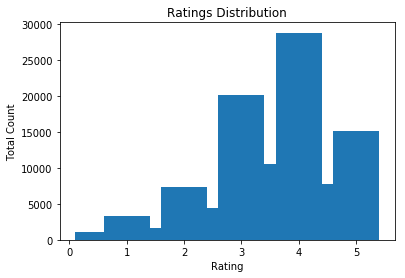

In [8]:
ratings_distribution = merged_df.groupby(['rating'],as_index=False)['rating'].agg({'total_count':'count'})
plt.bar(ratings_distribution['rating'],ratings_distribution['total_count'])
plt.xlabel('Rating')
plt.ylabel('Total Count')
plt.title('Ratings Distribution')
plt.show()

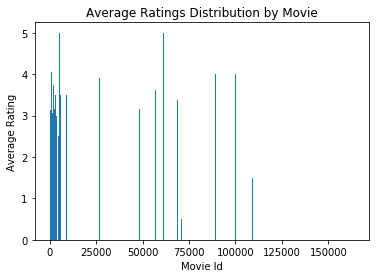

In [9]:
ratings_by_movie = merged_df_by_movieId.groupby(['movieId'],as_index=False)['rating'].mean()
plt.bar(ratings_by_movie['movieId'],ratings_by_movie['rating'])
plt.xlabel('Movie Id')
plt.ylabel('Average Rating')
plt.title('Average Ratings Distribution by Movie')
plt.show()

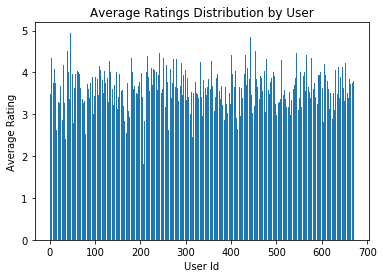

In [10]:
ratings_by_user = merged_df_by_movieId.groupby(['userId'],as_index=False)['rating'].mean()
plt.bar(ratings_by_user['userId'],ratings_by_user['rating'])
plt.xlabel('User Id')
plt.ylabel('Average Rating')
plt.title('Average Ratings Distribution by User')
plt.show()

#### Correlation Matrix 

In [11]:
merged_df_by_movieId.corr()

,userId,movieId,rating
userId,1.000000,0.007126,0.010467
movieId,0.007126,1.000000,-0.028894
rating,0.010467,-0.028894,1.000000


There is not a strong correlation between userId, movieId or rating. It's clear that a regression tree likely won't produce amazing results for this data set. To get value out of the regression tree, I will instead turn the movieId column into it's respective movie titles, making it categorical, and see if a prediction about a specific movie can be made given the title of the movie and the userId of who will be rating it.

<div style="page-break-after: always;"></div>

## Analysis

To begin with I will explain the code below. In order to build the regression tree, I have created a Node class which will be used to help me store and later traverse the tree that's been grown. 

### Question 1- Code: Defining the Functions

In [12]:
# This is the Node class for storage of the tree structure.
class Node:
    def __init__(self,parent,direction,value,label):
        self.parent = parent
        self.direction = direction
        self.label = label
        self.value = value
        self.children = []
    def add_child(self,node):
        self.children.append(node)
    def get_value(self):
        return(self.value)
    def get_label(self):
        return(self.label)
    def get_direction(self):
        return(self.direction)
    def get_children(self):
        return(self.children)
    def get_node_string(self):
        return ("Label:" + str(self.label) 
                + ",Value:" + str(self.value)
                + ",Parent:" + str(self.parent) 
                + ",Direction:" + str(self.direction))

In [13]:
## This is a function to let me traverse a tree and all it's children
def print_tree(node=None):
    if(node.get_label() == "leaf"):
        print(node.get_node_string())
    else:
        print(node.get_node_string())
        for i in node.get_children():
            print_tree(node=i)

In [14]:
# This is the MSE function from Equation 9.10 in the book.

def mean_squared_error(x):
    Nm = x.shape[0]
    result = 0 
    gm = sum(x)['rating']/Nm
    index_list = x.index.tolist()
    for i in index_list:
        rt = x['rating'][i]
        difference = (rt - gm)**2
        result = result + difference
    final_result = (1/Nm)*(result)
    return(final_result,gm)

In [15]:
# This is an implementation of equation 9.14 in the book

def split_mean_square_error(list_of_splits):
    result = 0
    Nm = 0
    num_of_splits = len(list_of_splits)

    #Nm is the values at all the node
    for i in range(0, num_of_splits):
        Nm = Nm + list_of_splits[i].shape[0]

    for i in range(0, num_of_splits):
        x = list_of_splits[i]
        gmj = sum(x)['rating']/x.shape[0]
        index_list = x.index.tolist()
        for j in index_list:
            rt = x['rating'][j]
            difference = (rt - gmj)**2
            result = result + difference
    
    final_result = (1/Nm)*result
    return(final_result)

In [16]:
# This is an implementation of the "SplitAttribute" function in figure 9.3 of the book.

def split_attribute(x):
    
    min_mse = 1000000000000000
    best_feature = 0
    number_of_attributes = len(list(x))
    size_of_x = x.shape[0]
    attributes = list(x)
    attribute_types = x.dtypes
    
    for i in range(0,number_of_attributes):
        if attributes[i] != 'rating':
            #if categorical
            if attribute_types[attributes[i]] == 'object':
                list_of_splits = []
                for j in x[attributes[i]].unique():
                    branch = x[x[attributes[i]] == j]
                    list_of_splits.append(branch)
                split_mse_val = split_mean_square_error(list_of_splits)                          
                if(split_mse_val<min_mse):
                    min_mse = split_mse_val
                    best_feature = attributes[i]
                    split_val = "category"
            #else is numeric
            else:
                x = x.sort_values(by=attributes[i])
                index_list = x.index.tolist()
                if(size_of_x >= 2):
                    for j in range(0,size_of_x-1):
                        x1 = x[0:(j+1)]
                        x2 = x[(j+1):size_of_x]
                        split_mse_val = split_mean_square_error([x1,x2])
                        if(split_mse_val<min_mse):
                            min_mse = split_mse_val
                            best_feature = attributes[i]
                            split_val = x[best_feature][index_list[j]]
                                          
    return(best_feature,split_val)

In [17]:
# This is the implementation of the GenerateTree function in figure 9.3 of the book.

def generateTree(x,
                 theta=0,
                 parent_node=None,
                 parent_attr="",
                 parent_split_val="",
                 direction="",
                 counter=0,
                 block_size=1):
    #print("Iteration: " + str(counter) + 
    #      " Direction: " + direction + 
    #      " Parent: " + parent_attr + "=" + str(parent_split_val))

    mse_val, gm = mean_squared_error(x)

    #print("MSE: " + str(mse_val) + " " + "Gm: " + str(gm))

    if (mse_val <= theta):
        node = Node(parent_attr + "=" + str(parent_split_val),direction,gm,"leaf")
        parent_node.add_child(node)
        
        #print("MSE Meets theta")
        #print("=================================================")
        
    else:
        #print("Finding Best Attribute...")

        chosen_attribute, split_val = split_attribute(x)

        #print("Chosen Attribute is: " + str(chosen_attribute))
        #print("Split Val is: " + str(split_val))
        #print("=================================================")
        
        if(type(split_val) == str):
            for j in x[chosen_attribute].unique():
                current_subset = x[x[chosen_attribute] == j]
                current_subset_size = current_subset.shape[0]
                split_node = Node(parent_attr + "=" + 
                                  str(parent_split_val),direction,chosen_attribute + 
                                  "=" + str(j),"node")
                parent_node.add_child(split_node)
                generateTree(current_subset,
                                theta,
                                split_node,
                                chosen_attribute,
                                j,
                                "=",
                                counter + 1,
                                block_size)
            
        else:
            if (chosen_attribute == parent_attr and split_val == parent_split_val) == False:

                split_node = Node(parent_attr + "=" + 
                                  str(parent_split_val),direction,chosen_attribute + "=" 
                                  + str(split_val),"node")
                parent_node.add_child(split_node)

                # left of branch
                current_subset = x[x[chosen_attribute] > split_val]
                current_subset_size = current_subset.shape[0]
                if (current_subset_size >= block_size):
                    generateTree(current_subset,
                                 theta,
                                 split_node,
                                 chosen_attribute,
                                 split_val,
                                 ">",
                                 counter + 1,
                                 block_size)
                else:
                    if (current_subset_size > 0):
                        mse_val, gm = mean_squared_error(current_subset)
                        if (mse_val <= theta):
                            node = Node(chosen_attribute + "=" + str(split_val),">",gm,"leaf")
                            split_node.add_child(node)

                # right of branch
                current_subset = x[x[chosen_attribute] <= split_val]
                current_subset_size = current_subset.shape[0]

                if (current_subset_size >= block_size):
                    generateTree(current_subset,
                                 theta,
                                 split_node,
                                 chosen_attribute,
                                 split_val,
                                 "<=",
                                 counter + 1,
                                 block_size)
                else:
                    if (current_subset_size > 0):
                        mse_val, gm = mean_squared_error(current_subset)
                        if (mse_val <= theta):
                            node = Node(chosen_attribute + "=" + str(split_val),"<=",gm,"leaf")
                            split_node.add_child(node)


In [18]:
# This is my tree traversal algorithm which will allow me to test the tree 
def test_tree(x,node=None):
    attribute_types = x.dtypes
    x_index_list = x.index.tolist()
    node_label = node.get_label()
    if(node_label == "leaf"):
        val = node.get_value()
        return val
    else:
        node_vals = node.get_value()
        if node_vals == "root":
            node_children = node.get_children()
            if(len(node_children)>1):
                for i in node_children:
                    node_vals = i.get_value().split("=")
                    attribute = node_vals[0]
                    split_val = node_vals[1]
                    if x[attribute][x_index_list[0]] == split_val:
                        return test_tree(x,i)
            else:
                return test_tree(x,node_children[0])
        else:
            node_children = node.get_children()
            node_vals = node_vals.split("=")
            attribute = node_vals[0]
            split_val = node_vals[1]
            
            if(attribute_types[attribute] == "object"):
                if x[attribute][x_index_list[0]] == split_val:
                    for i in node_children:
                        return test_tree(x,i)
            else:
                if x[attribute][x_index_list[0]] <= int(split_val):
                    for i in node_children:
                        if(i.get_direction() == "<="):
                            return test_tree(x,i)
                else:
                    node_children = node.get_children()
                    for i in node_children:
                        if(i.get_direction() == ">"):
                            return test_tree(x,i)     

In [30]:
def frange(min_val,max_val,step):
    temp = min_val
    while temp < max_val:
        yield temp
        temp = temp + step

In [31]:
#This is my test tree loop

def test_tree_loop(train_df,test_df,theta_min,theta_max,step):
    thetas = []
    test_error_vals = []
    for theta in frange(theta_min,theta_max,step):
        root_node = Node("root","root","root","root")
        print("=================================================")
        print("For Theta of: " + str(theta))
        print("=================================================")
        generateTree(x=train_df,theta=theta,
                     parent_node=root_node,
                     parent_attr="root",
                     parent_split_val=0,
                     direction="=",
                     counter=0,
                     block_size=1)
        print_tree(root_node)
        total_test_error = 0
        for i in range(0,len(test_df)):
            print("=================================================")
            x = test_df[i:i+1]
            print(x)
            index_list = x.index.tolist()
            prediction = test_tree(x,root_node)
            test_error = x['rating'][index_list[0]] - prediction
            total_test_error = total_test_error + test_error
            print("Predicition is: " + str(prediction))
            print("Test Error is: " + str(test_error))
            print("=================================================")
        test_error_vals.append(total_test_error)
        thetas.append(theta)
        print("Total Test Error is: " + str(total_test_error))
        print("=================================================")
    return(thetas,test_error_vals)

### Question 2 - Code: Training and Testing the Tree

Please see APPENDIX - RESULTS for the results of the training and testing of the tree. They are in this section as the ouput is quite long and reduces readability of the report.

### Question 3 - Analysis: Plotting Test Error

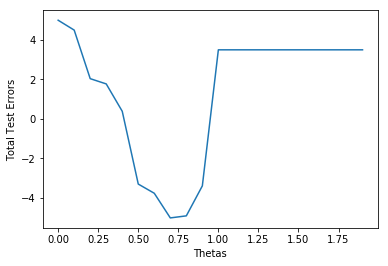

In [42]:
line, = plt.plot(thetas, error_vals, '-')
plt.ylabel('Total Test Errors')
plt.xlabel('Thetas')
plt.show()

As theta increases, the value decreases to a certain point. The ideal theta for this problem is roughly 0.5 

### Question 4 - Full Data Set

I attempted to run the code with the full dataset but the performance is not good. The runtime for creating the decision tree can be broken down into the following for a perfectly pure tree with MSE = 0:

- O(n) for creating each leaf as a perfectly pure tree will be fit to the training data thus creating a leaf for each row
- O((n-1)^2) for determing the split value for a numeric attribute
- O(d) for creating the split for a numeric value as we simply create the split based on the available unique values, where d is the number of unique values

The bottleneck in performance comes from the second runtime above, which is because the only real way to determine the best split value is to run through n-1 splits in the numeric data. Some strategies to over comes this might be to pre-sort the data which I did, and to find only the splits that matter ahead of time. That can include finding splits amongts data that can be pre-determined to be truly different or effectively "classed" differently. The most efficient sorting algorithm, a merge sort, operated on O(nlogn) time but can drastically reduce the need to go through each split especially if there is a strong correlation between variables. Alternatively much be done in a pre-processing stage to reduce noise in the data or remove outliers through outlier detection techniques.   

## APPENDIX - RESULTS

### Testing Categorical 

I tested using a created data set to make sure it properly performs for a categorical variables. I used the same data frame for both training and testing, expecting that the test error should be 0 for a theta of 0

In [47]:
d = {'test_category': ['test','test','test','suck','suck','suck','suck'],'rating': [1,1,1,4,4,4,4]}
df = pd.DataFrame(data=d)
thetas, error_vals = test_tree_loop(df,df,0,5,0.5)

For Theta of: 0
Label:root,Value:root,Parent:root,Direction:root
Label:node,Value:test_category=test,Parent:root=0,Direction:=
Label:leaf,Value:1.0,Parent:test_category=test,Direction:=
Label:node,Value:test_category=suck,Parent:root=0,Direction:=
Label:leaf,Value:4.0,Parent:test_category=suck,Direction:=
   rating test_category
0       1          test
Predicition is: 1.0
Test Error is: 0.0
   rating test_category
1       1          test
Predicition is: 1.0
Test Error is: 0.0
   rating test_category
2       1          test
Predicition is: 1.0
Test Error is: 0.0
   rating test_category
3       4          suck
Predicition is: 4.0
Test Error is: 0.0
   rating test_category
4       4          suck
Predicition is: 4.0
Test Error is: 0.0
   rating test_category
5       4          suck
Predicition is: 4.0
Test Error is: 0.0
   rating test_category
6       4          suck
Predicition is: 4.0
Test Error is: 0.0
Total Test Error is: 0.0
For Theta of: 0.5
Label:root,Value:root,Parent:root,Directi

   rating test_category
1       1          test
Predicition is: 2.7142857142857144
Test Error is: -1.71428571429
   rating test_category
2       1          test
Predicition is: 2.7142857142857144
Test Error is: -1.71428571429
   rating test_category
3       4          suck
Predicition is: 2.7142857142857144
Test Error is: 1.28571428571
   rating test_category
4       4          suck
Predicition is: 2.7142857142857144
Test Error is: 1.28571428571
   rating test_category
5       4          suck
Predicition is: 2.7142857142857144
Test Error is: 1.28571428571
   rating test_category
6       4          suck
Predicition is: 2.7142857142857144
Test Error is: 1.28571428571
Total Test Error is: -8.881784197e-16
For Theta of: 3.5
Label:root,Value:root,Parent:root,Direction:root
Label:leaf,Value:2.7142857142857144,Parent:root=0,Direction:=
   rating test_category
0       1          test
Predicition is: 2.7142857142857144
Test Error is: -1.71428571429
   rating test_category
1       1          tes

### Testing Numeric

I tested using a created data set to make sure it properly performs for a numeric variables. I used the same data frame for both training and testing, expecting that the test error should be 0 for a theta of 0

In [45]:
d = {'col1': [1,2,3,4,5,6],'rating': [2,4,6,8,10,12]}
df = pd.DataFrame(data=d)
thetas, error_vals = test_tree_loop(df,df,0,5,0.5)

For Theta of: 0
Label:root,Value:root,Parent:root,Direction:root
Label:node,Value:col1=3,Parent:root=0,Direction:=
Label:node,Value:col1=4,Parent:col1=3,Direction:>
Label:node,Value:col1=5,Parent:col1=4,Direction:>
Label:leaf,Value:12.0,Parent:col1=5,Direction:>
Label:leaf,Value:10.0,Parent:col1=5,Direction:<=
Label:leaf,Value:8.0,Parent:col1=4,Direction:<=
Label:node,Value:col1=1,Parent:col1=3,Direction:<=
Label:node,Value:col1=2,Parent:col1=1,Direction:>
Label:leaf,Value:6.0,Parent:col1=2,Direction:>
Label:leaf,Value:4.0,Parent:col1=2,Direction:<=
Label:leaf,Value:2.0,Parent:col1=1,Direction:<=
   col1  rating
0     1       2
Predicition is: 2.0
Test Error is: 0.0
   col1  rating
1     2       4
Predicition is: 4.0
Test Error is: 0.0
   col1  rating
2     3       6
Predicition is: 6.0
Test Error is: 0.0
   col1  rating
3     4       8
Predicition is: 8.0
Test Error is: 0.0
   col1  rating
4     5      10
Predicition is: 10.0
Test Error is: 0.0
   col1  rating
5     6      12
Predicit

### Testing Both Numeric and Categorical

I tested using a created data set to make sure it properly performs for a numeric and categorical variables when they are combined for prediction. I used the same data frame for both training and testing, expecting that the test error should be 0 for a theta of 0.

In [46]:
d = {'col1': [1,1,1,2,2,2],'test_category': ['test','suck','ts','test','suck','ts',],'rating': [1,1,3,1,2,2]}
df = pd.DataFrame(data=d)
thetas, error_vals = test_tree_loop(df,df,0,5,0.5)

For Theta of: 0
Label:root,Value:root,Parent:root,Direction:root
Label:node,Value:test_category=test,Parent:root=0,Direction:=
Label:leaf,Value:1.0,Parent:test_category=test,Direction:=
Label:node,Value:test_category=suck,Parent:root=0,Direction:=
Label:node,Value:col1=1,Parent:test_category=suck,Direction:=
Label:leaf,Value:2.0,Parent:col1=1,Direction:>
Label:leaf,Value:1.0,Parent:col1=1,Direction:<=
Label:node,Value:test_category=ts,Parent:root=0,Direction:=
Label:node,Value:col1=1,Parent:test_category=ts,Direction:=
Label:leaf,Value:2.0,Parent:col1=1,Direction:>
Label:leaf,Value:3.0,Parent:col1=1,Direction:<=
   col1  rating test_category
0     1       1          test
Predicition is: 1.0
Test Error is: 0.0
   col1  rating test_category
1     1       1          suck
Predicition is: 1.0
Test Error is: 0.0
   col1  rating test_category
2     1       3            ts
Predicition is: 3.0
Test Error is: 0.0
   col1  rating test_category
3     2       1          test
Predicition is: 1.0
Tes

Predicition is: 1.6666666666666667
Test Error is: -0.666666666667
   col1  rating test_category
4     2       2          suck
Predicition is: 1.6666666666666667
Test Error is: 0.333333333333
   col1  rating test_category
5     2       2            ts
Predicition is: 1.6666666666666667
Test Error is: 0.333333333333
Total Test Error is: -4.4408920985e-16
For Theta of: 4.5
Label:root,Value:root,Parent:root,Direction:root
Label:leaf,Value:1.6666666666666667,Parent:root=0,Direction:=
   col1  rating test_category
0     1       1          test
Predicition is: 1.6666666666666667
Test Error is: -0.666666666667
   col1  rating test_category
1     1       1          suck
Predicition is: 1.6666666666666667
Test Error is: -0.666666666667
   col1  rating test_category
2     1       3            ts
Predicition is: 1.6666666666666667
Test Error is: 1.33333333333
   col1  rating test_category
3     2       1          test
Predicition is: 1.6666666666666667
Test Error is: -0.666666666667
   col1  ratin

### Training and Testing the Movie Data Set

As the output of the results is quite extensive, please review the APPENDIX - RESULTS to see the output. I tested on a small set of the dataset, as it is quite not performant at a larger subset (anything above 500 rows is quite slow!). 

In [44]:
train_df = merged_df_by_title[0:200]
test_df = merged_df_by_title[200:240]
thetas, error_vals = test_tree_loop(train_df,test_df,0,2,0.1)

For Theta of: 0
Label:root,Value:root,Parent:root,Direction:root
Label:node,Value:userId=575,Parent:root=0,Direction:=
Label:node,Value:userId=584,Parent:userId=575,Direction:>
Label:node,Value:userId=670,Parent:userId=584,Direction:>
Label:leaf,Value:5.0,Parent:userId=670,Direction:>
Label:node,Value:userId=654,Parent:userId=670,Direction:<=
Label:node,Value:userId=660,Parent:userId=654,Direction:>
Label:leaf,Value:4.0,Parent:userId=660,Direction:>
Label:leaf,Value:2.5,Parent:userId=660,Direction:<=
Label:node,Value:userId=653,Parent:userId=654,Direction:<=
Label:leaf,Value:5.0,Parent:userId=653,Direction:>
Label:node,Value:userId=624,Parent:userId=653,Direction:<=
Label:node,Value:userId=636,Parent:userId=624,Direction:>
Label:node,Value:userId=646,Parent:userId=636,Direction:>
Label:leaf,Value:4.0,Parent:userId=646,Direction:>
Label:node,Value:userId=641,Parent:userId=646,Direction:<=
Label:leaf,Value:5.0,Parent:userId=641,Direction:>
Label:leaf,Value:4.0,Parent:userId=641,Direction

Label:node,Value:userId=292,Parent:userId=311,Direction:<=
Label:leaf,Value:3.0,Parent:userId=292,Direction:>
Label:node,Value:userId=285,Parent:userId=292,Direction:<=
Label:node,Value:userId=287,Parent:userId=285,Direction:>
Label:leaf,Value:4.0,Parent:userId=287,Direction:>
Label:leaf,Value:5.0,Parent:userId=287,Direction:<=
Label:leaf,Value:4.0,Parent:userId=285,Direction:<=
Label:node,Value:userId=282,Parent:userId=284,Direction:<=
Label:leaf,Value:3.0,Parent:userId=282,Direction:>
Label:leaf,Value:4.0,Parent:userId=282,Direction:<=
Label:node,Value:userId=268,Parent:userId=275,Direction:<=
Label:node,Value:userId=272,Parent:userId=268,Direction:>
Label:node,Value:userId=273,Parent:userId=272,Direction:>
Label:leaf,Value:5.0,Parent:userId=273,Direction:>
Label:leaf,Value:4.5,Parent:userId=273,Direction:<=
Label:leaf,Value:4.0,Parent:userId=272,Direction:<=
Label:leaf,Value:5.0,Parent:userId=268,Direction:<=
Label:node,Value:userId=253,Parent:userId=262,Direction:<=
Label:node,Valu

Label:leaf,Value:4.5,Parent:userId=240,Direction:<=
Label:node,Value:userId=219,Parent:userId=237,Direction:<=
Label:node,Value:userId=220,Parent:userId=219,Direction:>
Label:node,Value:userId=224,Parent:userId=220,Direction:>
Label:leaf,Value:3.0,Parent:userId=224,Direction:>
Label:leaf,Value:4.0,Parent:userId=224,Direction:<=
Label:leaf,Value:2.0,Parent:userId=220,Direction:<=
Label:node,Value:userId=215,Parent:userId=219,Direction:<=
Label:leaf,Value:5.0,Parent:userId=215,Direction:>
Label:leaf,Value:3.0,Parent:userId=215,Direction:<=
Label:node,Value:userId=176,Parent:userId=205,Direction:<=
Label:node,Value:userId=185,Parent:userId=176,Direction:>
Label:node,Value:userId=200,Parent:userId=185,Direction:>
Label:leaf,Value:4.75,Parent:userId=200,Direction:>
Label:node,Value:userId=193,Parent:userId=200,Direction:<=
Label:leaf,Value:3.0,Parent:userId=193,Direction:>
Label:leaf,Value:4.0,Parent:userId=193,Direction:<=
Label:node,Value:userId=178,Parent:userId=185,Direction:<=
Label:le

Label:leaf,Value:4.625,Parent:userId=128,Direction:<=
Label:node,Value:userId=112,Parent:userId=122,Direction:<=
Label:node,Value:userId=120,Parent:userId=112,Direction:>
Label:node,Value:userId=121,Parent:userId=120,Direction:>
Label:leaf,Value:3.0,Parent:userId=121,Direction:>
Label:leaf,Value:4.0,Parent:userId=121,Direction:<=
Label:leaf,Value:2.25,Parent:userId=120,Direction:<=
Label:node,Value:userId=97,Parent:userId=112,Direction:<=
Label:node,Value:userId=106,Parent:userId=97,Direction:>
Label:leaf,Value:5.0,Parent:userId=106,Direction:>
Label:leaf,Value:4.0,Parent:userId=106,Direction:<=
Label:node,Value:userId=94,Parent:userId=97,Direction:<=
Label:leaf,Value:1.0,Parent:userId=94,Direction:>
Label:node,Value:userId=79,Parent:userId=94,Direction:<=
Label:node,Value:userId=91,Parent:userId=79,Direction:>
Label:leaf,Value:4.0,Parent:userId=91,Direction:>
Label:leaf,Value:5.0,Parent:userId=91,Direction:<=
Label:node,Value:userId=77,Parent:userId=79,Direction:<=
Label:leaf,Value:2.

Label:leaf,Value:3.0,Parent:userId=7,Direction:<=
    userId             title  rating
93      89  Toy Story (1995)     5.0
Predicition is: 4.5
Test Error is: 0.5
     userId             title  rating
107     663  Toy Story (1995)     4.0
Predicition is: 4.0
Test Error is: 0.0
     userId             title  rating
109     294  Toy Story (1995)     4.0
Predicition is: 3.0
Test Error is: 1.0
     userId             title  rating
110     664  Toy Story (1995)     3.5
Predicition is: 4.0
Test Error is: -0.5
     userId             title  rating
111     559  Toy Story (1995)     4.0
Predicition is: 4.1875
Test Error is: -0.1875
     userId             title  rating
112      99  Toy Story (1995)     4.0
Predicition is: 4.333333333333333
Test Error is: -0.333333333333
     userId             title  rating
113      26  Toy Story (1995)     5.0
Predicition is: 4.0
Test Error is: 1.0
     userId             title  rating
114     136  Toy Story (1995)     4.5
Predicition is: 2.0
Test Error is: 2.

Label:root,Value:root,Parent:root,Direction:root
Label:node,Value:userId=575,Parent:root=0,Direction:=
Label:leaf,Value:4.2407407407407405,Parent:userId=575,Direction:>
Label:node,Value:userId=486,Parent:userId=575,Direction:<=
Label:node,Value:userId=500,Parent:userId=486,Direction:>
Label:node,Value:userId=564,Parent:userId=500,Direction:>
Label:node,Value:userId=570,Parent:userId=564,Direction:>
Label:leaf,Value:3.5,Parent:userId=570,Direction:>
Label:node,Value:userId=568,Parent:userId=570,Direction:<=
Label:leaf,Value:1.5,Parent:userId=568,Direction:>
Label:leaf,Value:3.0,Parent:userId=568,Direction:<=
Label:node,Value:userId=510,Parent:userId=564,Direction:<=
Label:leaf,Value:4.1875,Parent:userId=510,Direction:>
Label:node,Value:userId=509,Parent:userId=510,Direction:<=
Label:leaf,Value:1.0,Parent:userId=509,Direction:>
Label:node,Value:userId=506,Parent:userId=509,Direction:<=
Label:leaf,Value:3.0,Parent:userId=506,Direction:>
Label:leaf,Value:4.333333333333333,Parent:userId=506

     userId             title  rating
114     136  Toy Story (1995)     4.5
Predicition is: 2.8333333333333335
Test Error is: 1.66666666667
     userId             title  rating
115     553  Toy Story (1995)     4.0
Predicition is: 4.1875
Test Error is: -0.1875
    userId             title  rating
61      20  Toy Story (1995)     3.5
Predicition is: 2.6666666666666665
Test Error is: 0.833333333333
     userId             title  rating
117      84  Toy Story (1995)     3.5
Predicition is: 4.5
Test Error is: -1.0
     userId             title  rating
118     357  Toy Story (1995)     5.0
Predicition is: 3.0
Test Error is: 2.0
     userId             title  rating
119     306  Toy Story (1995)     3.0
Predicition is: 3.0
Test Error is: 0.0
     userId             title  rating
120     157  Toy Story (1995)     3.5
Predicition is: 3.0
Test Error is: 0.5
     userId             title  rating
121      30  Toy Story (1995)     4.0
Predicition is: 4.0
Test Error is: 0.0
     userId            

Test Error is: -1.28571428571
     userId             title  rating
120     157  Toy Story (1995)     3.5
Predicition is: 3.0
Test Error is: 0.5
     userId             title  rating
121      30  Toy Story (1995)     4.0
Predicition is: 4.178571428571429
Test Error is: -0.178571428571
     userId             title  rating
108     293  Toy Story (1995)     4.0
Predicition is: 4.285714285714286
Test Error is: -0.285714285714
    userId             title  rating
92     531  Toy Story (1995)     3.0
Predicition is: 4.1875
Test Error is: -1.1875
     userId             title  rating
116     358  Toy Story (1995)     5.0
Predicition is: 3.8333333333333335
Test Error is: 1.16666666667
    userId             title  rating
90     329  Toy Story (1995)     5.0
Predicition is: 4.285714285714286
Test Error is: 0.714285714286
    userId             title  rating
91     152  Toy Story (1995)     3.5
Predicition is: 4.5
Test Error is: -1.0
    userId             title  rating
64     580  Toy Story (1

     userId             title  rating
116     358  Toy Story (1995)     5.0
Predicition is: 3.95
Test Error is: 1.05
    userId             title  rating
90     329  Toy Story (1995)     5.0
Predicition is: 4.285714285714286
Test Error is: 0.714285714286
    userId             title  rating
91     152  Toy Story (1995)     3.5
Predicition is: 4.5
Test Error is: -1.0
    userId             title  rating
64     580  Toy Story (1995)     4.0
Predicition is: 4.2407407407407405
Test Error is: -0.240740740741
    userId             title  rating
65     491  Toy Story (1995)     5.0
Predicition is: 1.5
Test Error is: 3.5
    userId             title  rating
67     514  Toy Story (1995)     4.0
Predicition is: 4.1875
Test Error is: -0.1875
    userId             title  rating
68     561  Toy Story (1995)     3.0
Predicition is: 4.1875
Test Error is: -1.1875
    userId             title  rating
69     542  Toy Story (1995)     4.5
Predicition is: 4.1875
Test Error is: 0.3125
    userId         

    userId             title  rating
64     580  Toy Story (1995)     4.0
Predicition is: 4.2407407407407405
Test Error is: -0.240740740741
    userId             title  rating
65     491  Toy Story (1995)     5.0
Predicition is: 1.5
Test Error is: 3.5
    userId             title  rating
67     514  Toy Story (1995)     4.0
Predicition is: 4.1875
Test Error is: -0.1875
    userId             title  rating
68     561  Toy Story (1995)     3.0
Predicition is: 4.1875
Test Error is: -1.1875
    userId             title  rating
69     542  Toy Story (1995)     4.5
Predicition is: 4.1875
Test Error is: 0.3125
    userId             title  rating
70     313  Toy Story (1995)     4.0
Predicition is: 4.285714285714286
Test Error is: -0.285714285714
    userId             title  rating
71     345  Toy Story (1995)     4.5
Predicition is: 3.95
Test Error is: 0.55
    userId             title  rating
72     538  Toy Story (1995)     5.0
Predicition is: 4.1875
Test Error is: 0.8125
    userId     

Predicition is: 4.1875
Test Error is: -1.1875
    userId             title  rating
69     542  Toy Story (1995)     4.5
Predicition is: 4.1875
Test Error is: 0.3125
    userId             title  rating
70     313  Toy Story (1995)     4.0
Predicition is: 4.113636363636363
Test Error is: -0.113636363636
    userId             title  rating
71     345  Toy Story (1995)     4.5
Predicition is: 4.113636363636363
Test Error is: 0.386363636364
    userId             title  rating
72     538  Toy Story (1995)     5.0
Predicition is: 4.1875
Test Error is: 0.8125
    userId             title  rating
73     314  Toy Story (1995)     2.0
Predicition is: 4.113636363636363
Test Error is: -2.11363636364
    userId             title  rating
74      93  Toy Story (1995)     4.0
Predicition is: 4.5
Test Error is: -0.5
    userId             title  rating
75     518  Toy Story (1995)     5.0
Predicition is: 4.1875
Test Error is: 0.8125
    userId             title  rating
76     537  Toy Story (1995)   

     userId             title  rating
113      26  Toy Story (1995)     5.0
Predicition is: 3.8625
Test Error is: 1.1375
     userId             title  rating
114     136  Toy Story (1995)     4.5
Predicition is: 3.8625
Test Error is: 0.6375
     userId             title  rating
115     553  Toy Story (1995)     4.0
Predicition is: 3.8625
Test Error is: 0.1375
    userId             title  rating
61      20  Toy Story (1995)     3.5
Predicition is: 3.8625
Test Error is: -0.3625
     userId             title  rating
117      84  Toy Story (1995)     3.5
Predicition is: 3.8625
Test Error is: -0.3625
     userId             title  rating
118     357  Toy Story (1995)     5.0
Predicition is: 3.8625
Test Error is: 1.1375
     userId             title  rating
119     306  Toy Story (1995)     3.0
Predicition is: 3.8625
Test Error is: -0.8625
     userId             title  rating
120     157  Toy Story (1995)     3.5
Predicition is: 3.8625
Test Error is: -0.3625
     userId             title 

Predicition is: 3.8625
Test Error is: 1.1375
     userId             title  rating
114     136  Toy Story (1995)     4.5
Predicition is: 3.8625
Test Error is: 0.6375
     userId             title  rating
115     553  Toy Story (1995)     4.0
Predicition is: 3.8625
Test Error is: 0.1375
    userId             title  rating
61      20  Toy Story (1995)     3.5
Predicition is: 3.8625
Test Error is: -0.3625
     userId             title  rating
117      84  Toy Story (1995)     3.5
Predicition is: 3.8625
Test Error is: -0.3625
     userId             title  rating
118     357  Toy Story (1995)     5.0
Predicition is: 3.8625
Test Error is: 1.1375
     userId             title  rating
119     306  Toy Story (1995)     3.0
Predicition is: 3.8625
Test Error is: -0.8625
     userId             title  rating
120     157  Toy Story (1995)     3.5
Predicition is: 3.8625
Test Error is: -0.3625
     userId             title  rating
121      30  Toy Story (1995)     4.0
Predicition is: 3.8625
Test Er

    userId             title  rating
65     491  Toy Story (1995)     5.0
Predicition is: 3.8625
Test Error is: 1.1375
    userId             title  rating
67     514  Toy Story (1995)     4.0
Predicition is: 3.8625
Test Error is: 0.1375
    userId             title  rating
68     561  Toy Story (1995)     3.0
Predicition is: 3.8625
Test Error is: -0.8625
    userId             title  rating
69     542  Toy Story (1995)     4.5
Predicition is: 3.8625
Test Error is: 0.6375
    userId             title  rating
70     313  Toy Story (1995)     4.0
Predicition is: 3.8625
Test Error is: 0.1375
    userId             title  rating
71     345  Toy Story (1995)     4.5
Predicition is: 3.8625
Test Error is: 0.6375
    userId             title  rating
72     538  Toy Story (1995)     5.0
Predicition is: 3.8625
Test Error is: 1.1375
    userId             title  rating
73     314  Toy Story (1995)     2.0
Predicition is: 3.8625
Test Error is: -1.8625
    userId             title  rating
74      9